# Random Forest Regression PM10 correction model training
Testing the training of a combined St Ebbes & High St RF correction model for PM10.

## Import external modules

In [17]:
# Python library imports
# ------------------------
import datetime as dt
import pickle

%matplotlib inline
import sys

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import csv
import numpy as np
import pandas as pd
import pytz
import seaborn as sns
import sklearn
from matplotlib.dates import DateFormatter, MonthLocator
from matplotlib.ticker import FuncFormatter
from scipy import stats
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.pipeline import Pipeline

pd.plotting.register_matplotlib_converters()
# pd.set_option('display.max_colwidth', -1)

# File locations
# ----------------
data_home = './oxaria/processed/'
rf_home = './oxaria/processed/models/lockdown_paper/'
pngs = './oxaria/pngs/'

## Define local functions
Declare some functions for use later & reduce code repetition.

In [18]:
# Sensor data for colocated device at St Ebbes
# ----------------------------------------------
def load_pm104_training(folder,ftr_list, combo_cols):
    df_list = []
    tuple_list = zip(ftr_list, combo_cols)
    for f, c in tuple_list:
        # read the feather files
        dftmp = (
            pd.read_feather(folder + f)
            .set_index(['tag','rec'])
            .sort_index()
        )
        # Convert all float64 cols to float32
        cols = dftmp.select_dtypes(np.float64).columns
        dftmp[cols] = dftmp[cols].astype(np.float32)
        # Combine the reference method conc column into 1 column
        dftmp['pm10_ugg_combo'] = dftmp[c]
        # If its below 3 ug.m-3, its probably not, so set to nan
        dftmp['pm10_ugg_combo'] = np.where(
            dftmp['pm10_ugg_combo'] < 3.0, np.nan, dftmp['pm10_ugg_combo'])
        df_list.append(dftmp)    
    df_out = pd.concat(df_list)
    return df_out   

# Function to generate time lagged feature
# -----------------------------------------
def no2_feature_gen(df):
    # calc % change in all df cols over last 15 mins
    tmpdf1 = (
        df.apply(lambda x: pd.to_numeric(x, errors='coerce'))
        .dropna(axis=1, how='all')
        .pct_change(periods=1)
    )
    tmpdf1.columns = ['pc15_' + name for name in list(tmpdf1.columns)]
    # and same over last 30 mins
    tmpdf2 = (
        df.apply(lambda x: pd.to_numeric(x, errors='coerce'))
        .dropna(axis=1, how='all')
        .pct_change(periods=2)
    )
    tmpdf2.columns = ['pc30_' + name for name in list(tmpdf2.columns)]
    # merge % change stats back on to original df
    df = (
        df.merge(tmpdf1, left_index=True, right_index=True, how='left')
        .merge(tmpdf2, left_index=True, right_index=True, how='left')
        .set_index(['tag', 'rec'])
    )
    return df

# Function to generate rush hour & temporal flag features
# --------------------------------------------------------
def rushhour(df):
    # calc integer flags for hour of observation
    df['hour'] = df.index.get_level_values(1).hour
    # and day of week
    df['day'] = df.index.get_level_values(1).dayofweek
    # and integer flag(s) for off-peak, morning & evening rush hours
    df.loc[
        (df.index.get_level_values(1).time >= dt.time(7, 30, 0))
        & (df.index.get_level_values(1).time >= dt.time(9, 30, 0))
        & (df.index.get_level_values(1).weekday < 5),
        'rushhour',
    ] = 1
    df.loc[
        (df.index.get_level_values(1).time >= dt.time(16, 0, 0))
        & (df.index.get_level_values(1).time >= dt.time(18, 0, 0))
        & (df.index.get_level_values(1).weekday < 5),
        'rushhour',
    ] = 2
    df['rushhour'] = np.where(df['rushhour'] >= 1, df['rushhour'], 0).astype(np.int32)
    return df

# Function to constrain get training features for a soecific date envelope
#--------------------------------------------------------------------------
def get_training_pm10(dfs, env_start, env_stop):
    start = pd.to_datetime(env_start, infer_datetime_format=True, utc=True)
    end = pd.to_datetime(env_stop, infer_datetime_format=True, utc=True)
    
    print('Getting training features for sensors between: '+str(start)+' and '+str(end)+'\n')
    df_list = []
    
    for df in dfs:
        dftmp = df.query('@start <= rec < @end').reset_index().set_index(['tag','rec'])
        df_list.append(dftmp)
    
    df_out = pd.concat(df_list).sort_index()
    df_out = df_out[~df_out.index.duplicated()]
    df_out = df_out.loc[
        :,
        [
            'val.mtf1',
            'val.mtf5',
            'val.mtf3',
            'val.mtf7',
            'val.sfr',
            'val.hmd',
            'val.tmp',
            'pc15_val.mtf1',
            'pc15_val.mtf5',
            'pc15_val.mtf3',
            'pc15_val.mtf7',
            'pc15_val.sfr',
            'pc15_val.hmd',
            'pc15_val.tmp',
            'pc30_val.mtf1',
            'pc30_val.mtf5',
            'pc30_val.mtf3',
            'pc30_val.mtf7',
            'pc30_val.sfr',
            'pc30_val.hmd',
            'pc30_val.tmp',
            'hour',
            'day',
            'pm10_ugg_s',
            'pm25_ugg_s',
            'pm10_ugg_h',
            'pm10_ugg_combo',
            'val.pm10_1_c1',
            'pc15_val.pm10_1_c1',
            'pc30_val.pm10_1_c1',
        ],
    ]
    df_out = df_out.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
    print('Sensors in output :'+str(df_out.index.get_level_values(0).unique().tolist())+'\n')
    return df_out

# Define a function to test model performance based on a range of max. no, of leaf node sizes
# ---------------------------------------------------------------------------------------------
# The following function estimates mean absolute error as a metric for model
# accuracy.The number of trees used is set to 100 (i.e. n_estimators). 500 trees have also been tested but
# without any imporvement in accuracy so 100 is used to reduce training times.
def get_mae(max_leaf_nodes, train_X, val_X, train_y, val_y):

    # Define the model
    model = RandomForestRegressor(
        max_leaf_nodes=max_leaf_nodes, random_state=7, n_estimators=100, n_jobs=-1
    )

    # Create a v simple pipeline that imputes missing input values before fitting the model to them
    # -----------------------------------------------------------------------------------------------
    my_pipeline = Pipeline(steps=[('preprocessor', SimpleImputer()), ('model', model)])

    # Calculate a metric variable using the cross_val_score function
    # ----------------------------------------------------------------
    # The block below performs a cross validation excersise. For a given model configuration, it splits the
    # training set in 5 subsets and carries out a training sequence with the mean absolute error as a metric
    # of performance.
    # An avergae of those 5 MAE is then returned (see Figure below 'Validation' label).
    # This procedure ensures a robust training sequence as it removes the chance of
    # selecting a validation set that is very similar to the testing subset.
    #
    # Fit 5 random subsets of train_x & train_y to the pipeline RFR model & calc mean absolute error
    # multiply by -1 since sklearn calculates *negative* MAE
    metric = -1 * cross_val_score(
        my_pipeline, train_X, train_y, cv=5, scoring='neg_mean_absolute_error'
    )

    # Train the model
    my_pipeline.fit(train_X, train_y)

    # Predict dependent variable using validation & training subsets of independent variables
    preds_val = my_pipeline.predict(val_X)
    preds_tr = my_pipeline.predict(train_X)

    # MAE calculation for training and validation data
    mae_ver = mean_absolute_error(val_y, preds_val)
    mae_tr = mean_absolute_error(train_y, preds_tr)

    # Bring it all together in outputs
    return (mae_ver, mae_tr, metric.mean())


# Function to plot a storyboard of model validation
# --------------------------------------------------
def plot_training_story_board(df, title, save_it, *args):
    sns.set_style('white', {'axes.grid': False})
    fig, axes = plt.subplots(1, 3, figsize=(15, 4.3))
    fig.suptitle(
        title,
        y=1.1,
        fontsize=14,
    )
    plt.rcParams['ytick.labelsize'] = '12'
    plt.rcParams['xtick.labelsize'] = '12'
    plt.rcParams['figure.titlesize'] = '12'

    xlim = [0, 80]
    axes[0].set_xlim(xlim)

    # Get regression stats - sensor vs reference method
    slope, intercept, r_value, p_value, std_err = stats.linregress(
        train_df['val.pm10_1_c1'], train_df['pm10_ugg_combo']
    )
    # Plot it
    sns.regplot(
        x=train_df['pm10_ugg_combo'],
        y=train_df['val.pm10_1_c1'],
        color='tab:blue',
        line_kws={
            'label': 'y = {0:.3f}x+{1:.2f},  R-sqd = {3:.2f}'.format(
                slope, intercept, r_value, r_value ** 2
            )
        },
        ax=axes[0],
        truncate=False,
    )
    axes[0].set(
        xlabel='AURN PM10 (ugm-3)',
        ylabel='Sensor PM10 (ugm-3)',
        title='Uncorrected sensor vs Reference method\n (all observations)',
        xlim=(-100, 3000),
        ylim=(-100, 3000),
        xticks=(np.arange(0, 3200, 400)),
        yticks=(np.arange(0, 3200, 400)),
    )

    one = [0, 100, 3000]
    sns.regplot(
        x=one,
        y=one,
        color='k',
        line_kws={'label': '1:1', 'ls': ':', 'lw': 1},
        scatter_kws={'s': 0},
        ax=axes[0],
        ci=None,
    )

    axes[1].set_xlim(xlim)

    # Recalc regression stats - uncorrected validation subset sensor vs reference method
    slope, intercept, r_value, p_value, std_err = stats.linregress(
        val_y, val_X['val.pm10_1_c1']
    )
    # Plot it
    sns.regplot(
        x=val_y,
        y=val_X['val.pm10_1_c1'],
        color='tab:orange',
        line_kws={
            'label': 'y = {0:.2f}x+{1:.2f},  R-sqd = {3:.2f}'.format(
                slope, intercept, r_value, r_value ** 2
            )
        },
        ax=axes[1],
        truncate=False,
    )
    axes[1].set(
        xlabel='Reference method PM10 (ugm-3)',
        ylabel='Sensor PM10 (ugm-3)',
        title='Uncorrected sensor vs Reference method\n (validation subset)',
        xlim=(-100, 3000),
        ylim=(-100, 3000),
        xticks=(np.arange(0, 3200, 400)),
        yticks=(np.arange(0, 3200, 400)),
    )

    one = [0, 100, 3000]
    sns.regplot(
        x=one,
        y=one,
        color='k',
        line_kws={'label': '1:1', 'ls': ':', 'lw': 1},
        scatter_kws={'s': 0},
        ax=axes[1],
        ci=None,
    )

    axes[2].set_xlim(0, 100)

    # # Recalc regression stats - corrected validation subset sensor vs reference method
    slope, intercept, r_value, p_value, std_err = stats.linregress(val_y, model_prediction)
    sns.regplot(
        x=val_y,
        y=model_prediction,
        color='tab:green',
        line_kws={
            'label': 'y = {0:.2f}x+{1:.2f},  R-sqd = {3:.2f}'.format(
                slope, intercept, r_value, r_value ** 2
            )
        },
        ax=axes[2],
        truncate=False,
    )
    axes[2].set(
        xlabel='Reference method PM10 (ugm-3)',
        ylabel='Corrected Sensor PM10 (ugm-3)',
        title='Corrected sensor vs Reference method\n (validation subset)',
        xlim=(-2, 100),
        ylim=(-2, 100),
        xticks=(np.arange(0, 110, 20)),
        yticks=(np.arange(0, 110, 20)),
    )

    one = [0, 10, 100]
    sns.regplot(
        x=one,
        y=one,
        color='k',
        line_kws={'label': '1:1', 'ls': ':', 'lw': 1},
        scatter_kws={'s': 0},
        ax=axes[2],
        ci=None,
    )

    axes[0].legend(loc='upper center', fontsize=11)
    axes[1].legend(loc='upper center', fontsize=11)
    axes[2].legend(loc='upper center', fontsize=11)
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)
    plt.subplots_adjust(wspace=0.3)

    if save_it == True:
        plt.savefig(f'training_storyboard_pm10_mln{str(model.max_leaf_nodes)}_e{str(model.n_estimators)}_{png_descriptor}.png', dpi=300)
    plt.show()
    return

# Function for plotting the verification results - split
# -------------------------------------------------------
def timeseries_plot_split(val_X, val_y, title, save_it, **kwargs):
    # Model prediction
    # Set training & target variables
#     val_X = df.drop(
#         columns=['pm10_ugg_s', 'pm25_ugg_s', 'pm10_ugg_h', 'pm10_ugg_combo']
#     )  
#     val_y = df['pm10_ugg_combo']
    
    model_prediction = model.predict(val_X)
    sns.set_style('white', {'axes.grid': False})
    myFmt = mdates.DateFormatter('%b')
    f, (ax, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12, 6))
    sns.lineplot(
        x=val_y.index.get_level_values(1),
        y=val_y.values,
        label='Reference method target',
        color='k',
        lw=4,
        zorder=2,
        ax=ax,
    )
    sns.lineplot(
        x=val_X.index.get_level_values(1),
        y=model_prediction,
        label='Corrected sensor',
        color='tab:green',
        zorder=3,
        ax=ax,
    )
    sns.lineplot(
        x=val_X.index.get_level_values(1),
        y=val_X['val.pm10_1_c1'].values,
        label='Uncorrected sensor',
        color='tab:red',
        zorder=1,
        ax=ax,
    )
    sns.lineplot(
        x=val_y.index.get_level_values(1), 
        y=val_y.values, 
        color='k', 
        lw=4, 
        zorder=2, 
        ax=ax2
    )
    sns.lineplot(
        x=val_X.index.get_level_values(1),
        y=model_prediction,
        color='tab:green',
        zorder=3,
        ax=ax2,
    )
    sns.lineplot(
        x=val_X.index.get_level_values(1),
        y=val_X['val.pm10_1_c1'].values,
        color='tab:red',
        zorder=1,
        ax=ax2,
    )
    # zoom-in / limit the view to different portions of the data
    ax.set_ylim(500, 8000)  # outliers only
    ax2.set_ylim(-5, 130)  # most of the data

    # hide the spines between ax and ax2
    ax.spines['bottom'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax.xaxis.set_ticks_position('none')
    ax2.yaxis.set_label_coords(-0.05, 1.1)
    ax.yaxis.label.set_visible(False)

    d = 0.007  # how big to make the diagonal lines in axes coordinates
    # arguments to pass to plot, just so we don't keep repeating them
    kwargs = dict(transform=ax.transAxes, color='k', clip_on=False, lw=0.75)
    ax.plot((-d, +d), (-d, +d), **kwargs)  # top-left diagonal
    ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal
    ax2.xaxis.set_major_formatter(myFmt)
    kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
    ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
    ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

    # What's cool about this is that now if we vary the distance between
    # ax and ax2 via f.subplots_adjust(hspace=...) or plt.subplot_tool(),
    # the diagonal lines will move accordingly, and stay right at the tips
    # of the spines they are 'breaking'

    f.subplots_adjust(hspace=0.05)

    plt.ylabel('PM10 (ugm-3)', fontsize=11)
    ax.legend(loc='upper left', fontsize=11)
    ax.set_title(str(title),
        fontsize=14,
    )
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)
    if save_it is True:
        plt.savefig(f'split_validation_ts_pm10_mln{model.max_leaf_nodes}_e{model.n_estimators}_str({png_descriptor}).png',
           dpi=300)
    plt.show()
    

## Load training data

In [19]:
# Load training data 
#--------------------
# st ebbes
sebbes_files = ['batch_1_jan20_feb21/sebbes_train_536_s15_ratified.ftr','batch_2_feb21_may21/sebbes_train_536_s15_ratified+2021.ftr',
                'batch_3_jun21_oct21/sebbes_train_s15+2021_oct_update_transients.ftr']
sebbes_columns = ['pm10_ugg_s','pm10_ugg_s','pm10_ugg_s']

sebbes_train_s15 = load_pm104_training(data_home, sebbes_files, sebbes_columns)

# high st
highs_files = ['highs_train_536_s15_ratified.ftr','q12021/highs_train_536_s15_ratified+2021.ftr',
               'jun_to_sept_2021/sebbes_train_s15+2021_oct_update_transients_may22.ftr']
highs_columns = ['pm10_ugg_h','pm10_ugg_h','pm10_ugg_h']

highs_train_s15 = load_pm104_training(data_home, highs_files, highs_columns)


### Show sebbes & highs dataframe schemas

In [20]:
sebbes_train_s15.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 202170 entries, ('scs-bgx-538', Timestamp('2020-06-05 00:15:00+0000', tz='UTC')) to ('scs-bgx-538', Timestamp('2021-10-01 00:00:00+0000', tz='UTC'))
Data columns (total 98 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   val.no2.wev          202170 non-null  float32
 1   val.no2.cnc          202170 non-null  float32
 2   val.no2.aev          202170 non-null  float32
 3   val.no2.wec          202170 non-null  float32
 4   val.sht.hmd_g        202170 non-null  float32
 5   val.sht.tmp_g        202170 non-null  float32
 6   val.no2.cnc_1        201094 non-null  float32
 7   name                 73034 non-null   object 
 8   val.hmd              202170 non-null  float32
 9   val.tmp              202170 non-null  float32
 10  val.mtf1             202170 non-null  float32
 11  val.pm1              202170 non-null  float32
 12  val.mtf5             202170 non-null  float32
 13

In [21]:
highs_train_s15.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 192686 entries, ('scs-bgx-536', Timestamp('2020-09-25 00:15:00+0000', tz='UTC')) to ('scs-bgx-538', Timestamp('2021-10-01 00:00:00+0000', tz='UTC'))
Data columns (total 98 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   val.no2.wev          192686 non-null  float32
 1   val.no2.cnc          192686 non-null  float32
 2   val.no2.aev          192686 non-null  float32
 3   val.no2.wec          192686 non-null  float32
 4   val.sht.hmd_g        192686 non-null  float32
 5   val.sht.tmp_g        192686 non-null  float32
 6   val.no2.cnc_1        191553 non-null  float32
 7   name                 63550 non-null   object 
 8   val.hmd              192686 non-null  float32
 9   val.tmp              192686 non-null  float32
 10  val.mtf1             192686 non-null  float32
 11  val.pm1              192686 non-null  float32
 12  val.mtf5             192686 non-null  float32
 13

## Do some feature engineering

In [22]:
# Apply feature generation functions to St Ebbes training
# ---------------------------------------------------------
tmp_list = []
for tag, dat in sebbes_train_s15.reset_index().groupby('tag'):
    tmpdf = no2_feature_gen(dat)
    tmpdf = rushhour(tmpdf)
    tmp_list.append(tmpdf)
sebbes_train_s15_1 = pd.concat(tmp_list)

# Apply feature generation functions to High St training
# ---------------------------------------------------------
tmp_list = []
for tag, dat in highs_train_s15.reset_index().groupby('tag'):
    tmpdf = no2_feature_gen(dat)
    tmpdf = rushhour(tmpdf)
    tmp_list.append(tmpdf)
highs_train_s15_1 = pd.concat(tmp_list)

## Subset to constrain to training features
Select only interesting features & subset / constrain the training sample population to specific time envelope.

In [23]:
# Create the training dataset
#-----------------------------
train_df = get_training_pm10([sebbes_train_s15_1,highs_train_s15_1], '2020-06-01','2021-09-01')
train_df.info()

Getting training features for sensors between: 2020-06-01 00:00:00+00:00 and 2021-09-01 00:00:00+00:00

Sensors in output :['scs-bgx-536', 'scs-bgx-538']

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 46030 entries, ('scs-bgx-536', Timestamp('2020-09-25 01:00:00+0000', tz='UTC')) to ('scs-bgx-538', Timestamp('2021-08-31 23:45:00+0000', tz='UTC'))
Data columns (total 30 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   val.mtf1            46030 non-null  float64
 1   val.mtf5            46030 non-null  float64
 2   val.mtf3            46030 non-null  float64
 3   val.mtf7            46030 non-null  float64
 4   val.sfr             46030 non-null  float64
 5   val.hmd             46030 non-null  float64
 6   val.tmp             46030 non-null  float64
 7   pc15_val.mtf1       46030 non-null  float64
 8   pc15_val.mtf5       46030 non-null  float64
 9   pc15_val.mtf3       46030 non-null  float64
 10  pc15_val.mtf7       4

## Organise training data for Sklearn

In [24]:
# Define the training dataset. In this 1st cut using the full St Ebbes timeseries Jun-Nov
# ------------------------------------------------------------------------------------------

# Set training & target variables
X = train_df.drop(
    columns=['pm10_ugg_s', 'pm25_ugg_s', 'pm10_ugg_h', 'pm10_ugg_combo']
)  # remove target variable (i.e. no2) from training set.

y = train_df['pm10_ugg_combo']  # define target variable (i.e. no2).

# Split into training & validation (test) datasets for both dependent & independent variables
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=7, test_size=0.4)

## Fit & evaluate an RFR model

In [25]:
# Calculate model performance using MAE finction
# ------------------------------------------------

# Initialise vars with range of nodes to test
mini = 10
maxi = 10000
step = 500

candidate_max_leaf_nodes = np.arange(mini, maxi, step).tolist()

# Loop using dict comprehension to find the ideal tree size from number of nodes tested.
# The following line calls the get_mae function above for
# every value of nodes defined in candiate_max_leaf_nodes.
scores = {
    leaf_size: get_mae(leaf_size, train_X, val_X, train_y, val_y)
    for leaf_size in candidate_max_leaf_nodes
}
best_tree_size = min(scores, key=scores.get)

## Present results of K-fold cross validation evaluation of model performance

In [26]:
# Print leaf results
# --------------------
print(f'The best leaf node size between {mini} and {maxi} is:')
print(best_tree_size)
display(scores)

The best leaf node size between 10 and 10000 is:
9510


{10: (4.9851623550087805, 4.887284502818937, 4.918518832841335),
 510: (3.2243374612683313, 2.660278488769432, 3.278217037451045),
 1010: (2.986884944343158, 2.1192085123005184, 3.060812810810613),
 1510: (2.885289729762305, 1.8046849780131398, 2.971316742873011),
 2010: (2.8314790355080803, 1.596440326816686, 2.9264326213674563),
 2510: (2.801139601462449, 1.4505036963881268, 2.9019212827065397),
 3010: (2.78216381088886, 1.34524683329847, 2.888454975021096),
 3510: (2.7712678300186373, 1.2683994882123024, 2.881273312794435),
 4010: (2.7644012122305837, 1.2103507928351052, 2.8768937034964552),
 4510: (2.760448574915482, 1.167104694110153, 2.874514397643489),
 5010: (2.758076487597227, 1.1338642559241363, 2.87318145539219),
 5510: (2.755488240212776, 1.1088421776447526, 2.872269872914867),
 6010: (2.7541296074408184, 1.0898227369902405, 2.871899381938948),
 6510: (2.7537844933002793, 1.0753761412507699, 2.8712881895580185),
 7010: (2.753414310528905, 1.0641825515142507, 2.8709446396691

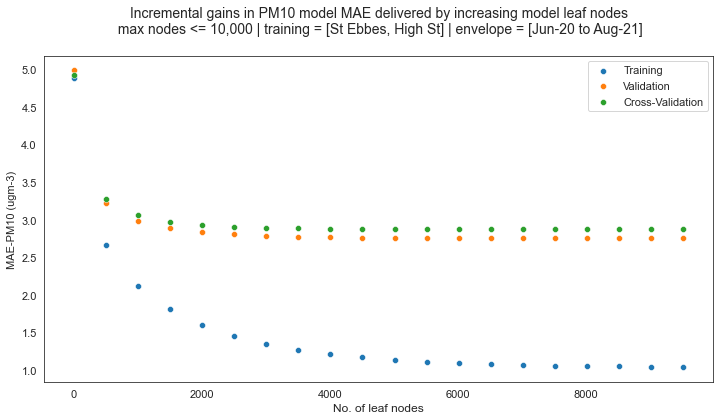

In [27]:
# Plot training & X validation results
# -------------------------------------
test = pd.DataFrame(scores)
plt.figure(figsize=(12, 6))

sns.scatterplot(x=test.columns, y=test.iloc[1], label='Training')
sns.scatterplot(x=test.columns, y=test.iloc[0], label='Validation')
sns.scatterplot(x=test.columns, y=test.iloc[2], label='Cross-Validation')

plt.ylabel('MAE-PM10 (ugm-3)', fontsize=11)
plt.xlabel('No. of leaf nodes', fontsize=12)
plt.title(
    'Incremental gains in PM10 model MAE delivered by increasing model leaf nodes\n \
max nodes <= 10,000 | training = [St Ebbes, High St] | envelope = [Jun-20 to Aug-21]\n',
    fontsize=14,
)
plt.legend(fontsize=11)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

# Save figure if needed
# plt.savefig(pngs + 'training_results_pm10_mln10000_e100_536_ratified_sebbes_highs.png', dpi=300)
plt.grid(False)
plt.show()

## Model training
From the above fig we can choose 6,000 leaf nodes as the point beyond which gains are margins & set our maximum leaf nodes to this value.

In [28]:
# Redefine the model using best tree size & number of estimators
# --------------------------------------------------
model = RandomForestRegressor(
    max_leaf_nodes=6000, random_state=7, n_estimators=100, n_jobs=-1
)

# fit the model
model.fit(train_X, train_y)
model_prediction = model.predict(val_X)

# Validation results

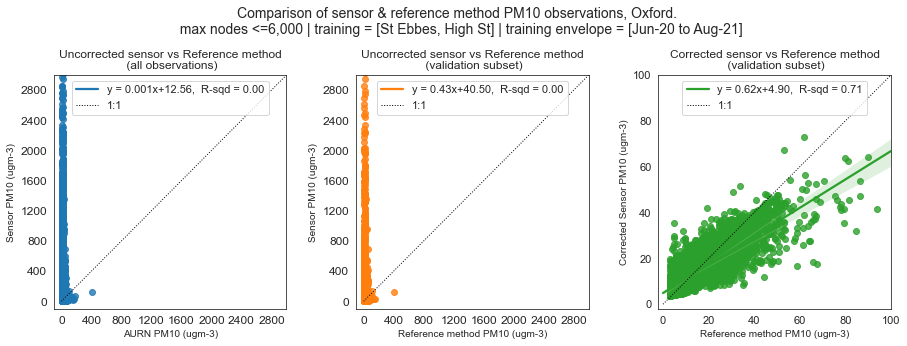

In [30]:
plot_training_story_board(train_df, 'Comparison of sensor & reference method PM10 observations, Oxford. \n \
max nodes <=6,000 | training = [St Ebbes, High St] | training envelope = [Jun-20 to Aug-21]\n', False)

## Time series of model performance hold-out validation set

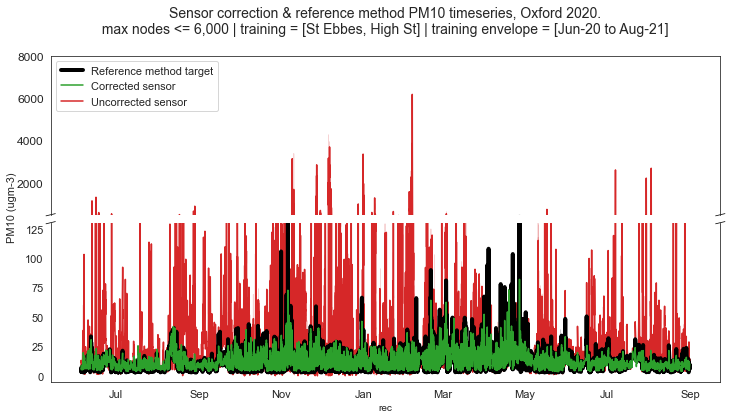

In [31]:
# Time series of validation hold out set
timeseries_plot_split(val_X=val_X, 
                      val_y=val_y,
                      title='Sensor correction & reference method PM10 timeseries, Oxford 2020.\n \
max nodes <= 6,000 | training = [St Ebbes, High St] | training envelope = [Jun-20 to Aug-21] \n',
                      save_it=False
                     )

## Calculate feature/parameter importance

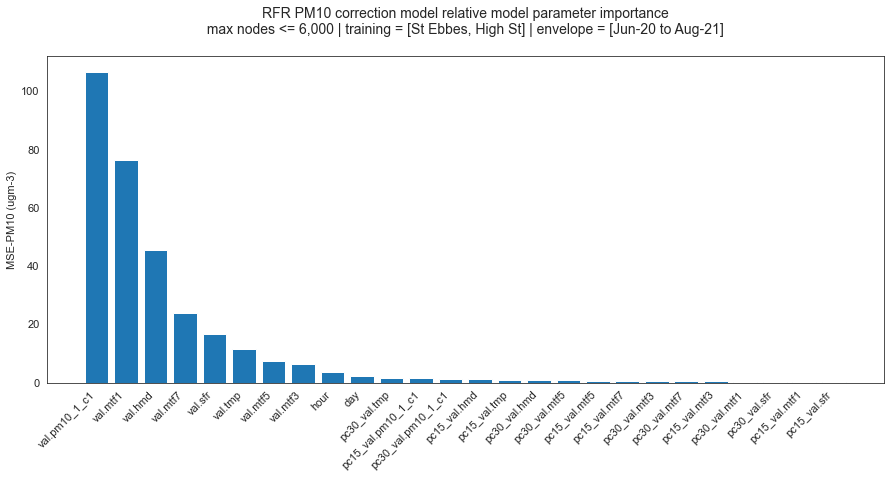

In [32]:
# Permutation importance is a method for determining how important a parameter is by sequentially
# shuffling model parameters and measuring the effect on model accuracy (MAE in this case)

# perform permutation importance
results = permutation_importance(
    model, train_X, train_y, scoring='neg_mean_squared_error'
)

# get importance
importance = results.importances_mean
importance = pd.DataFrame(importance, index=train_X.columns, columns=['MSE'])
importance = importance.sort_values(by='MSE', ascending=False)

sns.set_style('white', {'axes.grid': False})

fig = plt.figure(figsize=(15, 6))
ax1 = fig.add_subplot(111)
plt.bar(importance.index, importance.MSE)
plt.ylabel('MSE-PM10 (ugm-3)', fontsize=11)
ax1.xaxis.set_tick_params(rotation=45)
plt.setp(ax1.xaxis.get_majorticklabels(), ha='right', fontsize=12)
plt.title(
    'RFR PM10 correction model relative model parameter importance\n \
max nodes <= 6,000 | training = [St Ebbes, High St] | envelope = [Jun-20 to Aug-21] \n',
    fontsize=14,
)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

# Save figure if needed
# plt.savefig(pngs+'parameter_importance_pm10_mln6000_e100_536_sebbes_highs_ratified.png', dpi=300)
plt.show()

## Hold-out model validation set (val_y) vs reference
The hold-out validation set is 40% of the total training sample population.

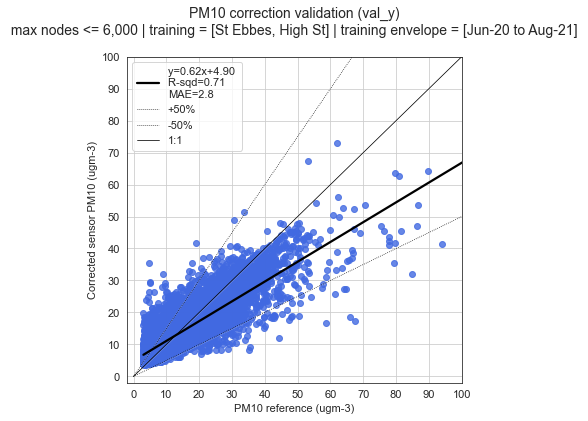

In [33]:
# Plot regression analysis of corrected verification sensor obs vs AURN
# -----------------------------------------------------------------------
sns.set_style('white', {'axes.grid': True})

one = [0, 20, 40, 60, 80, 110]
upper = [i * 1.50 for i in one]
lower = [i * 0.50 for i in one]

# Model prediction
model_prediction = model.predict(val_X)

slope, intercept, r_value, p_value, std_err = stats.linregress(val_y, model_prediction)
mae_veri = mean_absolute_error(val_y, model_prediction)
#mae_orig = mean_absolute_error(val_y, val_X['val.pm10_1_c1'])

fig = plt.figure(1, figsize=(6, 6))
fig.add_subplot(111)
ax1 = sns.regplot(
    x=val_y,
    y=model_prediction,
    color='royalblue',
    ci=None,
    line_kws={
        'label': 'y={0:.2f}x+{1:.2f} \nR-sqd={2:.2f} \nMAE={3:.1f}'.format(
            slope, intercept, r_value ** 2, mae_veri
        ),
        'color': 'k',
    },
)
ax2 = sns.regplot(
    x=one,
    y=upper,
    color='k',
    line_kws={'label': '+50%', 'ls': ':', 'lw': 0.75},
    scatter_kws={'s': 0},
)

ax3 = sns.regplot(
    x=one,
    y=lower,
    color='k',
    line_kws={'label': '-50%', 'ls': ':', 'lw': 0.75},
    scatter_kws={'s': 0},
)

ax4 = sns.regplot(
    x=one,
    y=one,
    color='k',
    line_kws={'label': '1:1', 'ls': '-', 'lw': 0.75},
    scatter_kws={'s': 0},
)

ax1.set_title(
    'PM10 correction validation (val_y)\n \
max nodes <= 6,000 | training = [St Ebbes, High St] | training envelope = [Jun-20 to Aug-21] \n',
    fontsize=14,
)
ax1.set_xlim(-2, 100)
ax1.set_ylim(-2, 100)
ax1.set_xticks(np.arange(0, 110, 10))
ax1.set_yticks(np.arange(0, 110, 10))
plt.legend(fontsize=11)
plt.ylabel('Corrected sensor PM10 (ugm-3)', fontsize=11)
plt.xlabel('PM10 reference (ugm-3)', fontsize=11)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

# Save figure if needed
plt.savefig('/home/tonyb/Gdrive/MinicondaProjects/oxaria/data/rf/gap_filling/536_method/ratified/oct_update/final_outputs/verification_regression_pm10_mln6000_e100_536_sebbes_highs_ratified.png', dpi=300)
plt.show()

## Save the model to disk

In [17]:
# Save the model to disk
#------------------------
filename = rf_home + 'RFR_model_pm10_mln6000_jun_aug_val_pm10_1_c2_SH_xt.sav'
pickle.dump(model, open(filename, 'wb'))

In [18]:
# Read the saved model to avoid all the working above
# -----------------------------------------------------
model = pickle.load(
    open(rf_home + 'RFR_model_pm10_mln6000_jun_aug_val_pm10_1_c2_SH_xt.sav', 'rb'))

## Export data for CEN uncertainty calculations

In [34]:
# Save the interesting variables to a csv for CEN expanded uncertainty calcs
# ----------------------------------------------------------------------------
import csv

outfile = list(
    zip(
        val_y.index.get_level_values(0),
        val_y.index.get_level_values(1).strftime('%m/%d/%Y %H:%M:%S'),
        val_y.values,
        model_prediction,
    )
)

with open(
    rf_home
    + 'values_for_cen_calc_RFR_model_pm10_mln6000_jun_aug_val_pm10_1_c2_SH_xt.csv',
    'w',
) as out:
    csv_out = csv.writer(out)
    csv_out.writerow(['tag', 'datetime', 'pm10_ugg_combo', 'val_pm10_1_c2_SH_xt'])
    csv_out.writerows(outfile)

# Print the  MAE stats for model configured with extra uniform backround time slots
# -----------------------------------------------------------------------------------
mae_veri = mean_absolute_error(val_y, model_prediction)
mae_orig = mean_absolute_error(val_y, val_X['val.pm10_1_c1'])

print(
    'MAE in uncorrected verifiction data for Jun to Nov with uniform baseline: '
    + str(mae_orig)
)
print(
    'MAE in corrected verifiction data for Jun to Nov with uniform baseline: '
    + str(mae_veri)
)
print('% 0.1f' % mae_orig, '% 0.1f' % mae_veri)

MAE in uncorrected verifiction data for Jun to Nov with uniform baseline: 36.79880056022107
MAE in corrected verifiction data for Jun to Nov with uniform baseline: 2.754136761735157
 36.8  2.8


# Model verification
Verifying model performance with data not used in model training or verification from September 2021.

Getting training features for sensors between: 2021-09-01 00:00:00+00:00 and 2021-10-01 00:00:00+00:00

Sensors in output :['scs-bgx-538']



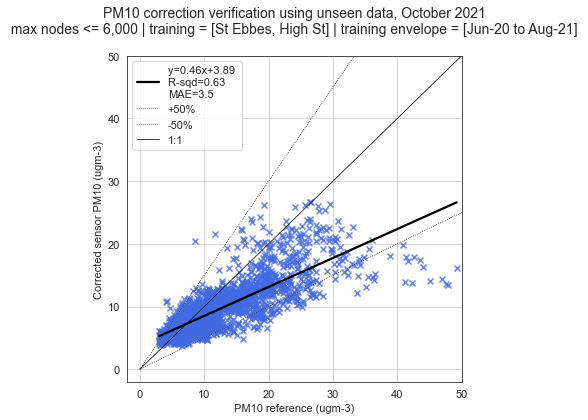

In [35]:
# Plotting the verification results using December 2020 data - split
# -------------------------------------------------------------------

# Generate out of sample / unseen verification set
verification_df = get_training_pm10([sebbes_train_s15_1,highs_train_s15_1],'2021-09-01','2021-10-01')
verification_df = verification_df.sort_index()

val_y = verification_df.loc[:, 'pm10_ugg_combo']
val_X = verification_df.drop(
    columns=['pm10_ugg_s', 'pm25_ugg_s', 'pm10_ugg_h', 'pm10_ugg_combo']
)

# Model prediction
model_prediction = model.predict(val_X)

sns.set_style('white', {'axes.grid': True})
myFmt = mdates.DateFormatter('%d-%b')

one = [0, 20, 40, 60, 80, 110]
upper = [i * 1.50 for i in one]
lower = [i * 0.50 for i in one]

# Model prediction
model_prediction = model.predict(val_X)

slope, intercept, r_value, p_value, std_err = stats.linregress(val_y, model_prediction)
mae_veri = mean_absolute_error(val_y, model_prediction)
#mae_orig = mean_absolute_error(val_y, val_X['val.pm10_1_c1'])

fig = plt.figure(1, figsize=(6, 6))
fig.add_subplot(111)
ax1 = sns.regplot(
    x=val_y,
    y=model_prediction,
    color='royalblue',
    marker = 'x',
    ci=None,
    line_kws={
        'label': 'y={0:.2f}x+{1:.2f} \nR-sqd={2:.2f} \nMAE={3:.1f}'.format(
            slope, intercept, r_value ** 2, mae_veri
        ),
        'color': 'k',
    },
)
ax2 = sns.regplot(
    x=one,
    y=upper,
    color='k',
    line_kws={'label': '+50%', 'ls': ':', 'lw': 0.75},
    scatter_kws={'s': 0},
)

ax3 = sns.regplot(
    x=one,
    y=lower,
    color='k',
    line_kws={'label': '-50%', 'ls': ':', 'lw': 0.75},
    scatter_kws={'s': 0},
)

ax4 = sns.regplot(
    x=one,
    y=one,
    color='k',
    line_kws={'label': '1:1', 'ls': '-', 'lw': 0.75},
    scatter_kws={'s': 0},
)

ax1.set_title(
    'PM10 correction verification using unseen data, October 2021\n \
max nodes <= 6,000 | training = [St Ebbes, High St] | training envelope = [Jun-20 to Aug-21] \n',
    fontsize=14,
)
ax1.set_xlim(-2, 50)
ax1.set_ylim(-2, 50)
ax1.set_xticks(np.arange(0, 52, 10))
ax1.set_yticks(np.arange(0, 52, 10))
plt.legend(fontsize=11)
plt.ylabel('Corrected sensor PM10 (ugm-3)', fontsize=11)
plt.xlabel('PM10 reference (ugm-3)', fontsize=11)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.savefig('/home/tonyb/Gdrive/MinicondaProjects/oxaria/data/rf/gap_filling/536_method/ratified/oct_update/final_outputs/verification_regression_pm10_mln6000_e100_536_sebbes_highs_ratified_unseen.png',
            dpi=300)
plt.show()

## Time series verifying model performance on unseen data

Getting training features for sensors between: 2021-09-01 00:00:00+00:00 and 2021-10-01 00:00:00+00:00

Sensors in output :['scs-bgx-538']



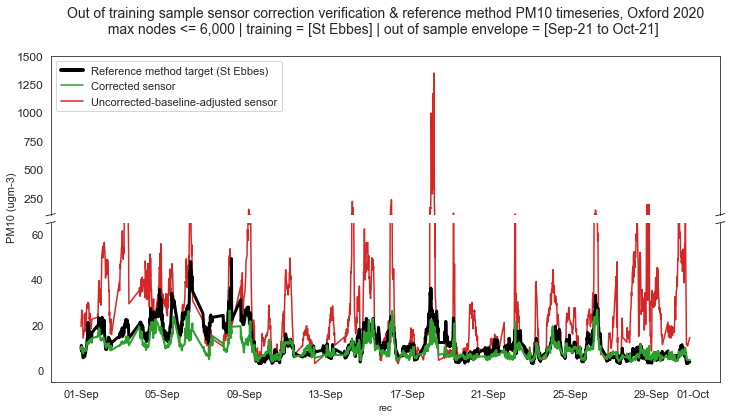

In [37]:
# Plotting the verification results using December 2020 data - split
# -------------------------------------------------------------------

# Generate out of sample / unseen verification set
verification_df = get_training_pm10([sebbes_train_s15_1,highs_train_s15_1],'2021-09-01','2021-10-01')
verification_df = verification_df.sort_index()

val_y = verification_df.loc[:, 'pm10_ugg_combo']
val_X = verification_df.drop(
    columns=['pm10_ugg_s', 'pm25_ugg_s', 'pm10_ugg_h', 'pm10_ugg_combo']
)

# Model prediction
model_prediction = model.predict(val_X)

sns.set_style('white', {'axes.grid': False})
myFmt = mdates.DateFormatter('%d-%b')

f, (ax, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12, 6))

sns.lineplot(
    x=val_y.index.get_level_values(1),
    y=val_y.values,
    label='Reference method target (St Ebbes)',
    color='k',
    lw=4,
    zorder=2,
    ax=ax,
)

sns.lineplot(
    x=val_X.index.get_level_values(1),
    y=model_prediction,
    label='Corrected sensor',
    color='tab:green',
    zorder=3,
    ax=ax,
)
sns.lineplot(
    x=val_X.index.get_level_values(1),
    y=val_X['val.pm10_1_c1'],
    label='Uncorrected-baseline-adjusted sensor',
    color='tab:red',
    zorder=1,
    ax=ax,
)
sns.lineplot(
    x=val_y.index.get_level_values(1), 
    y=val_y.values, 
    color='k', 
    lw=3, 
    zorder=4, 
    ax=ax2
)
sns.lineplot(
    x=val_X.index.get_level_values(1),
    y=model_prediction,
    color='tab:green',
    lw=2,
    zorder=5,
    ax=ax2,
)
sns.lineplot(
    x=val_X.index.get_level_values(1),
    y=val_X['val.pm10_1_c1'],
    color='tab:red',
    zorder=2,
    ax=ax2,
)

# zoom-in / limit the view to different portions of the data
ax.set_ylim(100, 1500)  # outliers only
ax2.set_ylim(-5, 65)  # most of the data

# hide the spines between ax and ax2
ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.xaxis.set_ticks_position('none')
ax2.yaxis.set_label_coords(-0.05, 1.1)
ax.yaxis.label.set_visible(False)

d = 0.007  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False, lw=0.75)
ax.plot((-d, +d), (-d, +d), **kwargs)  # top-left diagonal
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal
ax2.xaxis.set_major_formatter(myFmt)
kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

# What's cool about this is that now if we vary the distance between
# ax and ax2 via f.subplots_adjust(hspace=...) or plt.subplot_tool(),
# the diagonal lines will move accordingly, and stay right at the tips
# of the spines they are 'breaking'

f.subplots_adjust(hspace=0.05)

plt.ylabel('PM10 (ugm-3)', fontsize=11)
ax.legend(loc='upper left', fontsize=11)
ax.set_title(
    'Out of training sample sensor correction verification & reference method PM10 timeseries, Oxford 2020\n \
max nodes <= 6,000 | training = [St Ebbes] | out of sample envelope = [Sep-21 to Oct-21]  \n',
    fontsize=14,
)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
# plt.savefig(pngs + 'verification_results_pm10_mln6000_e100_536_sebbes_highs_ratified_dec_split.png', dpi=300)
plt.show()

## Export data for CEN uncertainty calculations

In [38]:
# Save the interesting variables to a csv for CEN expanded uncertainty calcs
# ----------------------------------------------------------------------------
outfile = list(zip(val_X.index.get_level_values(0), val_X.index.get_level_values(1), val_y.values, model_prediction))

with open(
    rf_home + 'values_for_cen_calc_RFR_model_pm10_mln6000_jun_aug_val_pm10_1_c2_SH_xt_unseen.csv', 'w') as out:
    csv_out = csv.writer(out)
    csv_out.writerow(['tag', 'rec', 'pm10_ugg_combo', 'val.pm10_1_c2_SH_xt'])
    csv_out.writerows(outfile)

mae_veri = mean_absolute_error(val_y.values, model_prediction)
mae_orig = mean_absolute_error(val_y.values, val_X['val.pm10_1_c1'])

print('MAE in uncorrected verifiction data for December: ' + str(mae_orig))
print('MAE in corrected verifiction data for December: ' + str(mae_veri))
print('% 0.1f' % mae_orig, '% 0.1f' % mae_veri)

MAE in uncorrected verifiction data for December: 20.00457
MAE in corrected verifiction data for December: 3.5399833694253164
 20.0  3.5


## Time series showing model performance across the full study period

Getting training features for sensors between: 2020-06-01 00:00:00+00:00 and 2021-10-01 00:00:00+00:00

Sensors in output :['scs-bgx-536', 'scs-bgx-538']



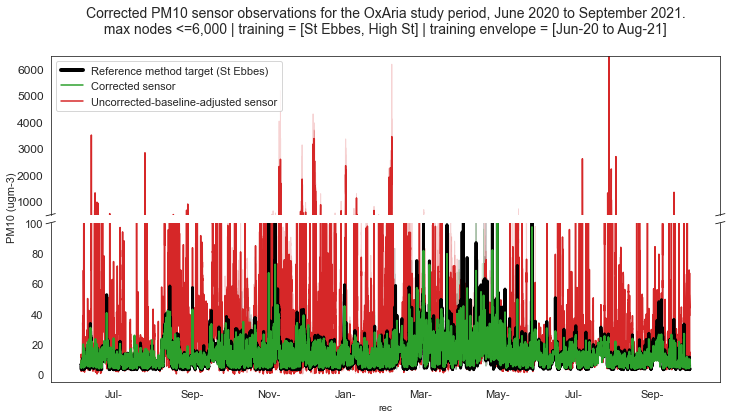

In [39]:
# Plotting the fullstudy results using December 2020 data - split
# --------------------------------------------------------------------

# Generate out of sample / unseen verification set
study_period_df = get_training_pm10([sebbes_train_s15_1,highs_train_s15_1],'2020-06-01','2021-10-01')

study_period_df = study_period_df.sort_index()
val_y = study_period_df.loc[:, 'pm10_ugg_combo']
val_X = study_period_df.drop(
    columns=['pm10_ugg_s', 'pm25_ugg_s', 'pm10_ugg_h', 'pm10_ugg_combo']
)

# Model prediction
model_prediction = model.predict(val_X)

sns.set_style('white', {'axes.grid': False})
myFmt = mdates.DateFormatter('%b-')

f, (ax, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12, 6))

sns.lineplot(
    x=val_y.index.get_level_values(1),
    y=val_y.values,
    label='Reference method target (St Ebbes)',
    color='k',
    lw=4,
    zorder=2,
    ax=ax,
)

sns.lineplot(
    x=val_X.index.get_level_values(1),
    y=model_prediction,
    label='Corrected sensor',
    color='tab:green',
    zorder=3,
    ax=ax,
)
sns.lineplot(
    x=val_X.index.get_level_values(1),
    y=val_X['val.pm10_1_c1'],
    label='Uncorrected-baseline-adjusted sensor',
    color='tab:red',
    zorder=1,
    ax=ax,
)
sns.lineplot(
    x=val_y.index.get_level_values(1), 
    y=val_y.values, 
    color='k', 
    lw=3, 
    zorder=4, 
    ax=ax2
)
sns.lineplot(
    x=val_X.index.get_level_values(1),
    y=model_prediction,
    color='tab:green',
    lw=2,
    zorder=5,
    ax=ax2,
)
sns.lineplot(
    x=val_X.index.get_level_values(1),
    y=val_X['val.pm10_1_c1'],
    color='tab:red',
    zorder=2,
    ax=ax2,
)

# zoom-in / limit the view to different portions of the data
ax.set_ylim(500, 6500)  # outliers only
ax2.set_ylim(-5, 100)  # most of the data

# hide the spines between ax and ax2
ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.xaxis.set_ticks_position('none')
ax2.yaxis.set_label_coords(-0.05, 1.1)
ax.yaxis.label.set_visible(False)

d = 0.007  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False, lw=0.75)
ax.plot((-d, +d), (-d, +d), **kwargs)  # top-left diagonal
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal
ax2.xaxis.set_major_formatter(myFmt)
kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

# What's cool about this is that now if we vary the distance between
# ax and ax2 via f.subplots_adjust(hspace=...) or plt.subplot_tool(),
# the diagonal lines will move accordingly, and stay right at the tips
# of the spines they are 'breaking'

f.subplots_adjust(hspace=0.05)

plt.ylabel('PM10 (ugm-3)', fontsize=11)
ax.legend(loc='upper left', fontsize=11)
ax.set_title(
    'Corrected PM10 sensor observations for the OxAria study period, June 2020 to September 2021.\n \
max nodes <=6,000 | training = [St Ebbes, High St] | training envelope = [Jun-20 to Aug-21] \n',
    fontsize=14,
)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
# plt.savefig(pngs + 'verification_results_pm10_mln6000_e100_536_sebbes_highs_ratified_dec_split.png', dpi=300)
plt.show()

## Regression plot of 15-minute averaged corrected sensor PM10 observations vs reference method

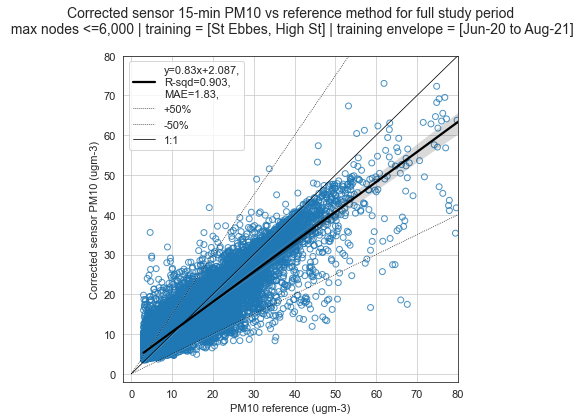

In [43]:
# Plot regression analysis of corrected verification sensor obs vs AURN
# -----------------------------------------------------------------------
study_period_df.sort_index(inplace=True)
val_y = study_period_df.loc[:, 'pm10_ugg_combo']
val_X = study_period_df.drop(
    columns=['pm10_ugg_s', 'pm25_ugg_s', 'pm10_ugg_h', 'pm10_ugg_combo']
)

# Model prediction
model_prediction = model.predict(val_X)

sns.set_style('white', {'axes.grid': True})

one = [0, 20, 40, 60, 80, 100]
upper = [i * 1.50 for i in one]
lower = [i * 0.50 for i in one]

slope, intercept, r_value, p_value, std_err = stats.linregress(
    val_y.values, model_prediction
)
mae_veri = mean_absolute_error(val_y.values, model_prediction)
# mae_orig = mean_absolute_error(val_y, val_X['val.pm10_1_c1'])

fig = plt.figure(1, figsize=(6, 6))
fig.add_subplot(111)
ax1 = sns.regplot(
    x=val_y.values,
    y=model_prediction,
    color='tab:blue',
    marker='o',
    line_kws={
        'label': 'y={0:.2f}x+{1:.2f},\nR-sqd={2:.4f},\nMAE={3:.2f},\nMAE orig={4:.2f}'.format(
            slope, intercept, r_value**2, mae_veri, mae_orig
        ),
        'color': 'k',
    },
    scatter_kws={'s': 35, 'facecolors': 'none'},
)
ax2 = sns.regplot(
    x=one,
    y=upper,
    color='k',
    line_kws={'label': '+50%', 'ls': ':', 'lw': 0.75},
    scatter_kws={'s': 0},
)

ax3 = sns.regplot(
    x=one,
    y=lower,
    color='k',
    line_kws={'label': '-50%', 'ls': ':', 'lw': 0.75},
    scatter_kws={'s': 0},
)

ax4 = sns.regplot(
    x=one,
    y=one,
    color='k',
    line_kws={'label': '1:1', 'ls': '-', 'lw': 0.75},
    scatter_kws={'s': 0},
)

ax1.set_title(
    'Corrected sensor 15-min PM10 vs reference method for full study period\n \
max nodes <=6,000 | training = [St Ebbes, High St] | training envelope = [Jun-20 to Aug-21]\n',
    fontsize=14,
)
ax1.set_xlim(-2, 80)
ax1.set_ylim(-2, 80)
ax1.set_xticks(np.arange(0, 85, 10))
ax1.set_yticks(np.arange(0, 85, 10))
plt.legend(fontsize=11)
plt.ylabel('Corrected sensor PM10 (ugm-3)', fontsize=11)
plt.xlabel('PM10 reference (ugm-3)', fontsize=11)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

# Save figure if needed
# plt.savefig(pngs + 'verification_regression_pm10_mln6000_e100_536_sebbes_highs_ratified_combo.png',
#            dpi=300)
plt.show()

## Regression plot of 1-hour averaged corrected sensor PM10 observations vs reference method

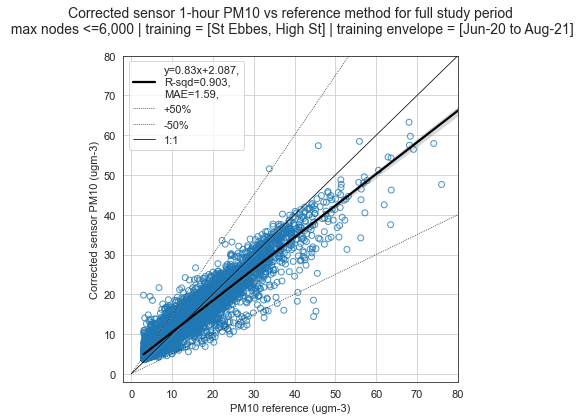

In [44]:
# Plot regression analysis of corrected verification sensor obs vs AURN
# -----------------------------------------------------------------------
sns.set_style('white', {'axes.grid': True})

one = [0, 20, 40, 60, 80, 100]
upper = [i * 1.50 for i in one]
lower = [i * 0.50 for i in one]

study_period_df.sort_index(inplace=True)
val_y = study_period_df.loc[:, 'pm10_ugg_combo']
val_X = study_period_df.drop(
    columns=['pm10_ugg_s', 'pm25_ugg_s', 'pm10_ugg_h', 'pm10_ugg_combo']
)

# Model prediction
model_prediction = model.predict(val_X)

dftmp0 = pd.concat(
    [val_y.reset_index(), pd.DataFrame(model_prediction, columns=['model_prediction'])],
    axis=1,
).set_index(['tag', 'rec'])

dftmp1 = dftmp0.groupby(
    [
        pd.Grouper(level='tag'),
        pd.Grouper(
            level='rec', freq='1H', label='right', convention='end', origin='epoch'
        ),
    ]
).mean()


slope, intercept, r_value, p_value, std_err = stats.linregress(
    dftmp1.iloc[:, 0].values, dftmp1.iloc[:, 1].values
)
mae_veri = mean_absolute_error(dftmp1.iloc[:, 0].values, dftmp1.iloc[:, 1].values)
# mae_orig = mean_absolute_error(val_y, val_X['val.pm10_1_c1'])

fig = plt.figure(1, figsize=(6, 6))
fig.add_subplot(111)
ax1 = sns.regplot(
    x=dftmp1.iloc[:, 0].values,
    y=dftmp1.iloc[:, 1].values,
    color='tab:blue',
    marker='o',
    line_kws={
        'label': 'y={0:.2f}x+{1:.2f},\nR-sqd={2:.2f}\nMAE={3:.1f}'.format(
            slope, intercept, r_value**2, mae_veri, mae_orig
        ),
        'color': 'k',
    },
    scatter_kws={'s': 35, 'facecolors': 'none'},
)
ax2 = sns.regplot(
    x=one,
    y=upper,
    color='k',
    line_kws={'label': '+50%', 'ls': ':', 'lw': 0.75},
    scatter_kws={'s': 0},
)

ax3 = sns.regplot(
    x=one,
    y=lower,
    color='k',
    line_kws={'label': '-50%', 'ls': ':', 'lw': 0.75},
    scatter_kws={'s': 0},
)

ax4 = sns.regplot(
    x=one,
    y=one,
    color='k',
    line_kws={'label': '1:1', 'ls': '-', 'lw': 0.75},
    scatter_kws={'s': 0},
)

ax1.set_title(
    'Corrected sensor 1-hour PM10 vs reference method for full study period\n \
max nodes <=6,000 | training = [St Ebbes, High St] | training envelope = [Jun-20 to Aug-21]\n',
    fontsize=14,
)
ax1.set_xlim(-2, 80)
ax1.set_ylim(-2, 80)
ax1.set_xticks(np.arange(0, 85, 10))
ax1.set_yticks(np.arange(0, 85, 10))
plt.legend(fontsize=11)
plt.ylabel('Corrected sensor PM10 (ugm-3)', fontsize=11)
plt.xlabel('PM10 reference (ugm-3)', fontsize=11)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

# Save figre if needed
plt.savefig(pngs + 'verification_regression_pm10_mln6000_e100_536_sebbes_highs_ratified_combo_1hr.png',
            dpi=300)
plt.show()

# Save the interesting variables to a csv for CEN expanded uncertainty calcs
# ----------------------------------------------------------------------------
outfile = list(
    zip(
        dftmp1.index.get_level_values(0),
        dftmp1.index.get_level_values(1).strftime('%m/%d/%Y %H:%M:%S'),
        dftmp1['pm10_ugg_combo'].values,
        dftmp1['model_prediction'].values
    )
)

with open(
    rf_home
    + 'values_for_cen_calc_RFR_model_pm10_mln6000_jun_aug_val_pm10_1_c2_SH_xt_1hr.csv',
    'w',
) as out:
    csv_out = csv.writer(out)
    csv_out.writerow(['tag', 'datetime', 'pm10_ugg_combo', 'val_pm10_1_c2_SH_xt'])
    csv_out.writerows(outfile)

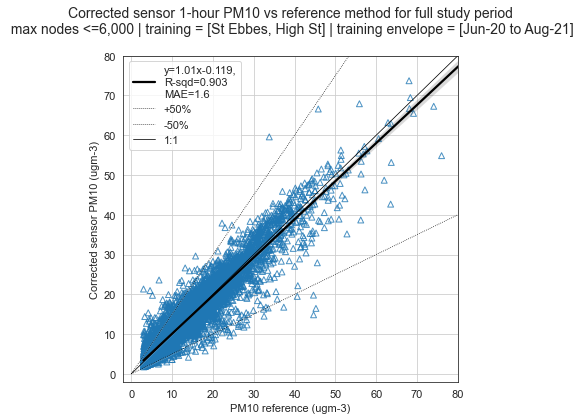

In [49]:
# Plot regression analysis of corrected verification sensor obs vs AURN
# -----------------------------------------------------------------------
sns.set_style('white', {'axes.grid': True})

one = [0, 20, 40, 60, 80, 100]
upper = [i * 1.50 for i in one]
lower = [i * 0.50 for i in one]

study_period_df.sort_index(inplace=True)
val_y = study_period_df.loc[:, 'pm10_ugg_combo']
val_X = study_period_df.drop(
    columns=['pm10_ugg_s', 'pm25_ugg_s', 'pm10_ugg_h', 'pm10_ugg_combo']
)

# Model prediction
model_prediction = (model.predict(val_X) - 2.087) / 0.83

dftmp0 = pd.concat(
    [val_y.reset_index(), pd.DataFrame(model_prediction, columns=['model_prediction'])],
    axis=1,
).set_index(['tag', 'rec'])

dftmp1 = dftmp0.groupby(
    [
        pd.Grouper(level='tag'),
        pd.Grouper(
            level='rec', freq='1H', label='right', convention='end', origin='epoch'
        ),
    ]
).mean()


slope, intercept, r_value, p_value, std_err = stats.linregress(
    dftmp1.iloc[:, 0].values, dftmp1.iloc[:, 1].values
)
mae_veri = mean_absolute_error(dftmp1.iloc[:, 0].values, dftmp1.iloc[:, 1].values)
# mae_orig = mean_absolute_error(val_y, val_X['val.pm10_1_c1'])

fig = plt.figure(1, figsize=(6, 6))
fig.add_subplot(111)
ax1 = sns.regplot(
    x=dftmp1.iloc[:, 0].values,
    y=dftmp1.iloc[:, 1].values,
    color='tab:blue',
    marker='^',
    line_kws={
        'label': 'y=1.01x-0.119,\nR-sqd=0.903\nMAE={3:.1f}'.format(
            slope, intercept, r_value**2, mae_veri, mae_orig
        ),
        'color': 'k',
    },
    scatter_kws={'s': 35, 'facecolors': 'none'},
)
ax2 = sns.regplot(
    x=one,
    y=upper,
    color='k',
    line_kws={'label': '+50%', 'ls': ':', 'lw': 0.75},
    scatter_kws={'s': 0},
)

ax3 = sns.regplot(
    x=one,
    y=lower,
    color='k',
    line_kws={'label': '-50%', 'ls': ':', 'lw': 0.75},
    scatter_kws={'s': 0},
)

ax4 = sns.regplot(
    x=one,
    y=one,
    color='k',
    line_kws={'label': '1:1', 'ls': '-', 'lw': 0.75},
    scatter_kws={'s': 0},
)

ax1.set_title(
    'Corrected sensor 1-hour PM10 vs reference method for full study period\n \
max nodes <=6,000 | training = [St Ebbes, High St] | training envelope = [Jun-20 to Aug-21]\n',
    fontsize=14,
)
ax1.set_xlim(-2, 80)
ax1.set_ylim(-2, 80)
ax1.set_xticks(np.arange(0, 85, 10))
ax1.set_yticks(np.arange(0, 85, 10))
plt.legend(fontsize=11)
plt.ylabel('Corrected sensor PM10 (ugm-3)', fontsize=11)
plt.xlabel('PM10 reference (ugm-3)', fontsize=11)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

# Save figre if needed
plt.savefig(pngs + 'verification_regression_pm10_mln6000_e100_536_sebbes_highs_ratified_combo_1hr_corrected.png',
            dpi=300)
plt.show()


In [27]:
dftmp1

pm10_ugg_combo  model_prediction
tag         rec                                                        
scs-bgx-536 2020-09-25 02:00:00+00:00        7.150000          8.351603
            2020-09-25 03:00:00+00:00       14.650000         14.703890
            2020-09-25 04:00:00+00:00       12.075000         11.638922
            2020-09-25 05:00:00+00:00       12.275000         11.786637
            2020-09-25 06:00:00+00:00       10.825000         11.570492
...                                               ...               ...
scs-bgx-538 2021-09-30 15:00:00+00:00        7.175000          7.994624
            2021-09-30 16:00:00+00:00        6.900000          8.847667
            2021-09-30 17:00:00+00:00        3.866667          6.347325
            2021-09-30 18:00:00+00:00        3.350000          4.585924
            2021-09-30 21:00:00+00:00        3.800000          4.696214

[12950 rows x 2 columns]

## Scatter plots of corrected PM10 vs reference concentration colour scaled by magnitude of selected interferents

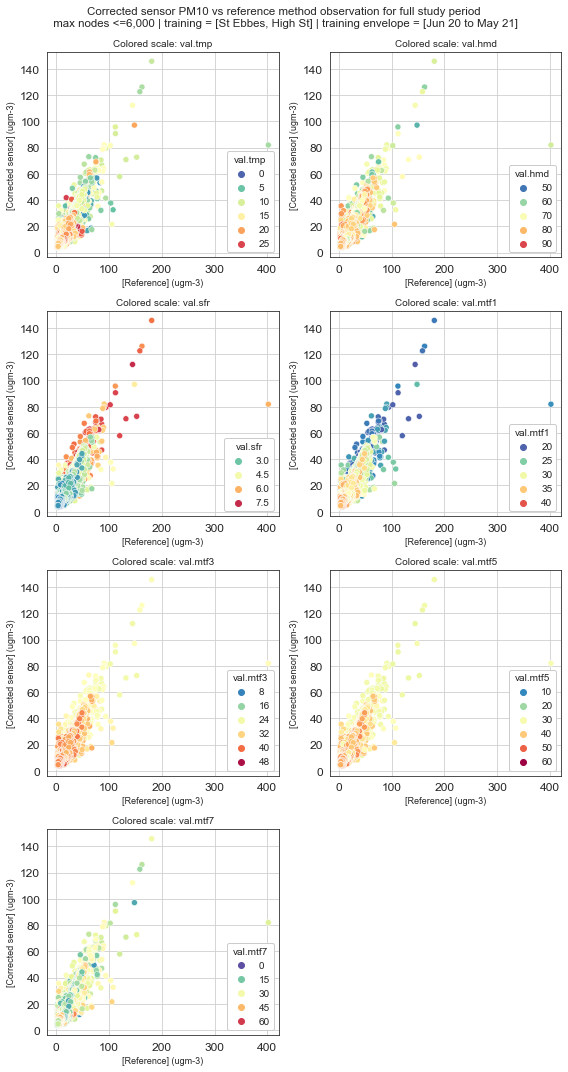

In [26]:
# Scatter plots of corrected vs reference & feature importance for the study period  
study_period_df.sort_index(inplace=True)
val_y = study_period_df.loc[:, 'pm10_ugg_combo']
val_X = study_period_df.drop(
    columns=['pm10_ugg_s', 'pm25_ugg_s', 'pm10_ugg_h', 'pm10_ugg_combo']
)
model_prediction = model.predict(val_X)

plot_list = ['val.tmp', 'val.hmd', 'val.sfr', 'val.mtf1', 'val.mtf3', 'val.mtf5', 'val.mtf7']

cmap_r = color_map = plt.cm.get_cmap('Spectral').reversed()

fig, axes = plt.subplots(nrows=4, ncols=2, sharex=False, sharey=False, figsize=(8,15))
axes_list = [item for sublist in axes for item in sublist] 

fig.suptitle('Corrected sensor PM10 vs reference method observation for full study period\n \
max nodes <=6,000 | training = [St Ebbes, High St] | training envelope = [Jun 20 to May 21]', fontsize=11.5, y=0.99)

for i in plot_list:
    ax = axes_list.pop(0)
    sns.scatterplot(x=val_y, y=model_prediction, hue=val_X[i], ax=ax, palette=cmap_r)
    ax.set_title(f'Colored scale: {i}', fontsize=10)
    ax.set_ylabel('[Corrected sensor] (ugm-3)', fontsize=9)
    ax.set_xlabel('[Reference] (ugm-3)', fontsize=9)
    ax.legend(frameon=True, framealpha=0.99, loc='lower right', title=i)
    ax.grid(True)
fig.delaxes(axes_list[-1])
plt.tight_layout()
   
plt.show()

